## Notebook for visualizing chemical space in reduced dimensions

### Fig: 4c

**Created on 31st December, 2023; modified on February 14, 2024**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['figure.figsize'] = (4, 3)
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ps.fonttype'] = 42
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as py
import colorsys
import os, sys
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from typing import List
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, rdMolDescriptors, Fragments
import optuna
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import rankdata
import scipy
from scipy.spatial.distance import pdist, squareform

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
import plotly.express as px
from IPython.display import SVG, display
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
# output_notebook()

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Chem-Mater-R1/manuscript-plots
total 69112
-rw-r--r--@ 1 riteshk  staff    52049 Jan 22 15:03 plot_cond_expt_valid_ml_fig5b_012225.eps
-rw-r--r--  1 riteshk  staff      208 Jan 22 15:03 act_energy_expt_valid_ml_fig5b_012225.csv
-rw-------@ 1 riteshk  staff   844288 Jan 29 08:14 emol_expt_measured_022324_.xls
-rw-r--r--@ 1 riteshk  staff    19694 Jan 29 08:16 plot_oxstab_expt-ml-dft_fig_5c_012925.eps
-rw-r--r--@ 1 riteshk  staff    19540 Jan 29 08:20 plot_ce_expt-ml_fig5d_012925.eps
-rw-r--r--@ 1 riteshk  staff   169633 Jan 29 09:26 plot_fig5bcd.ai
-rw-r--r--@ 1 riteshk  staff   819279 Jan 29 09:26 plot_fig5bcd.jpg
-rw-r--r--  1 riteshk  staff     3688 Jan 29 14:50 preds_expt_chemprop_strat_expt_error.csv
-rw-r--r--@ 1 riteshk  staff    20494 Jan 31 14:40 plot_ce_expt-ml_fig5d_013125.eps
-rw-------@ 1 riteshk  staff    53858 Jan 31 14:40 compare-ml-expt_ce_fig5c.ipynb
-rw-r--r--@ 1 riteshk  staff    50709

In [45]:
df = pd.read_csv('fig4_data_02132024.csv')
df['solv_comb_sm'] = df['solv_comb_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
X_tsne = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(24), allow_pickle=True)
df['tsne_0'] = X_tsne[:,0]
df['tsne_1'] = X_tsne[:,1]
df ## note: 'score' column refers to predicted eScore values for unlabeled compounds from eMolecules, PubChem, and GDB17 databases & to CE values for labeled compounds from literature (training & OOD)

solv_comb_sm     score    database     class     tsne_0  \
0                      N#CC(F)Cl  0.640642  emolecules  Nitriles -40.520080   
1                     CC(C#N)C#N  0.637202  emolecules  Nitriles -39.789117   
2                     COC(=O)C#N  0.632583  emolecules    Esters  -3.742554   
3                       N#CC(F)F  0.631385  emolecules  Nitriles -40.468889   
4               CC(=O)OC(C#N)C#N  0.625274  emolecules    Esters -12.921387   
...                          ...       ...         ...       ...        ...   
62547       CS(=O)(=O)OCC(F)(F)F  0.991400       known    Others -24.342435   
62548            FC(F)(F)C1COCO1  0.985000       known     Ether  47.847478   
62549  FC(F)(F)COCCOCCOCC(F)(F)F  0.991411       known     Ether -47.611665   
62550                    FCCOCCF  0.997000       known     Ether -21.717168   
62551              FCCOCCOCCOCCF  0.874748       known     Ether -21.758317   

          tsne_1  
0      26.269161  
1      24.924783  
2      49.067006  
3      26.255678  
4      76.461929  
...          ...  
62547   5.672320  
62548 -27.333889  
62549 -36.590871  
62550 -52.049601  
62551 -52.072518  

[62552 rows x 6 columns]

In [16]:
# df[['solv_comb_sm', 'score', 'database', 'tsne_0', 'tsne_1']].to_csv('data_fig4c_tsne.csv', index=False)

In [7]:
def gen_color_gradient(color):
    # Convert the RGB values to HSL
    r, g, b = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    # Decrease the lightness value by 10%
    l -= 0.1 ## + will increase intensity
    # Convert the HSL values back to RGB
    r_, g_, b_ = colorsys.hls_to_rgb(h, l, s)
    return (r_, g_, b_)

In [8]:
def create_cmap(listval, color):
    vmin = min(listval)
    vmax = max(listval)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mcolors.LinearSegmentedColormap.from_list('', [(norm(vmin), 'white'), (norm(vmax), color)])
    return cmap, norm

def create_cmap_log(listval, color):
    vmin = min(listval)
    vmax = max(listval)
    norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
    cmap = mcolors.LinearSegmentedColormap.from_list('', [(norm(vmin), 'white'), (norm(vmax), color)])
    return cmap, norm

In [9]:
df['database'].unique()

array(['emolecules', 'pubchem', 'gdb17', 'known'], dtype=object)

In [52]:
df.sort_values('score', ascending=True, inplace=True)
df

solv_comb_sm     score    database   class  \
4636                               CCN1CCOCC1  0.000000  emolecules   Ether   
59777  CC(C)(C)N(CCC(C)(C)C(C)(C)C)S(C)(=O)=O  0.464021     pubchem  Others   
59776             COC(C)CCO[Si](C)(C)C(C)(C)C  0.464027     pubchem   Ether   
62476           CCCOC(C)(C)C1OC(C)(C)C(C)C1CC  0.464110       gdb17   Ether   
59775                      CCN(CC)P1(=S)SCCS1  0.464347     pubchem  Others   
...                                       ...       ...         ...     ...   
62520                     FC(F)COCCOCC(F)(F)F  0.995000       known   Ether   
62541                        COCC(OC)C(F)(F)F  0.996000       known   Ether   
62497                                      CF  0.996500       known  Others   
62550                                 FCCOCCF  0.997000       known   Ether   
62527                                   O=C=O  0.999000       known  Others   

          tsne_0     tsne_1  
4636    3.175537 -63.210487  
59777 -15.231645  32.797865  
59776 -59.542907  29.633317  
62476  60.948591 -60.287914  
59775  -6.053659 -56.372787  
...          ...        ...  
62520 -48.879734 -35.445132  
62541 -78.945992 -35.863208  
62497  -5.253914 -22.791264  
62550 -21.717168 -52.049601  
62527  -5.168965 -13.939551  

[62552 rows x 6 columns]

In [53]:
emol = df.loc[df['database'] == 'emolecules']
pub = df.loc[df['database'] == 'pubchem']
gdb = df.loc[df['database'] == 'gdb17']
known = df.loc[df['database'] == 'known']
unknown = pd.concat([emol, pub, gdb], axis=0)
unknown

solv_comb_sm     score    database    class  \
4636                           CCN1CCOCC1  0.000000  emolecules    Ether   
4635     CC(C)C(=O)N1CCCC(C(=O)N2CCCC2)C1  0.466756  emolecules   Others   
4634      CC(C)C(=O)N1CCCN(C(=O)C(C)C)CC1  0.467290  emolecules   Others   
4633                CCOP(OCC)O[Si](C)(C)C  0.467305  emolecules   Others   
4632        CCOC1CSC2(C1)CN(C(=O)C(C)C)C2  0.467612  emolecules    Ether   
...                                   ...       ...         ...      ...   
59782    CCC1(OC(=O)C#N)OC(=O)CC1C(=O)C=O  0.581672       gdb17   Esters   
59781    CCC1(S(=O)(=O)C=O)OC(=O)C(C#N)O1  0.585228       gdb17  Sulfone   
59780  CC1CC(OC(=O)C#N)(C(=O)C=O)OC(=O)O1  0.587212       gdb17   Esters   
59779       CC1OC(C#N)(C=O)C(C)(C#N)OC1=O  0.588744       gdb17   Esters   
59778                 CC(=O)OC(C)(C#N)C#N  0.623322       gdb17   Esters   

           tsne_0     tsne_1  
4636     3.175537 -63.210487  
4635    56.750879  62.795759  
4634    51.321451  61.465422  
4633   -26.018647 -73.093292  
4632    58.449959  65.362709  
...           ...        ...  
59782  114.741333   3.072549  
59781  110.732635  13.870191  
59780  113.299732   9.830026  
59779  103.421275  -3.068476  
59778   11.233413  77.749087  

[62477 rows x 6 columns]

In [54]:
known['score_1'] = known['score'].apply(lambda x: -np.log10(1-x))
known

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_73253/2760727266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known['score_1'] = known['score'].apply(lambda x: -np.log10(1-x))


solv_comb_sm     score database      class      tsne_0  \
62524   O=C1OCC(C(F)(F)F)O1  0.542000    known  Carbonate  106.568050   
62532  CCCCCC[Si](OC)(OC)OC  0.857000    known     Others   -6.005348   
62482          CC1COC(=O)O1  0.862000    known  Carbonate  101.636788   
62500             COC(=O)OC  0.867542    known  Carbonate   -2.918249   
62551         FCCOCCOCCOCCF  0.874748    known      Ether  -21.758317   
...                     ...       ...      ...        ...         ...   
62520   FC(F)COCCOCC(F)(F)F  0.995000    known      Ether  -48.879734   
62541      COCC(OC)C(F)(F)F  0.996000    known      Ether  -78.945992   
62497                    CF  0.996500    known     Others   -5.253914   
62550               FCCOCCF  0.997000    known      Ether  -21.717168   
62527                 O=C=O  0.999000    known     Others   -5.168965   

          tsne_1   score_1  
62524  30.640136  0.339135  
62532 -96.562729  0.844664  
62482  22.878708  0.860121  
62500  85.351571  0.877921  
62551 -52.072518  0.902214  
...          ...       ...  
62520 -35.445132  2.301030  
62541 -35.863208  2.397940  
62497 -22.791264  2.455932  
62550 -52.049601  2.522879  
62527 -13.939551  3.000000  

[75 rows x 7 columns]

In [55]:
# unknown[mask1_2]['score'].min(), unknown[mask1_2]['score'].max()

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_73253/1654014164.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unknown[mask1_2]['score'].min(), unknown[mask1_2]['score'].max()
/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_73253/1654014164.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unknown[mask1_2]['score'].min(), unknown[mask1_2]['score'].max()


(0.0, 0.6325830510863646)

In [13]:
smiles = ['CCN1CCOCC1', 'COC(=O)C#N', 'CCS(=O)(=O)F', 'CCOCCS(=O)(=O)F', 'COCCOC', 'COCC(F)(F)C(F)(F)COC', 'FC(F)(F)COCCOCCOCC(F)(F)F']
std_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(sm)) for sm in smiles]

In [18]:
# df.loc[df['solv_comb_sm'] == 'CCN1CCOCC1']['score'] = 1e-6 ## assign a score of 1e-6 to the EM
# df.loc[df['solv_comb_sm'] == 'CCN1CCOCC1', 'score'] = 0.0 ## assign a score of 1e-3 to the EM
# df.loc[df['solv_comb_sm'] == 'CCN1CCOCC1']
# df.loc[df['solv_comb_sm'] == std_smiles[3]]
# df.loc[df['solv_comb_sm'] == std_smiles[6]]
# df.loc[df['solv_comb_sm'] == std_smiles[5]]
# df.loc[df['solv_comb_sm'] == std_smiles[4]]
# df.loc[df['solv_comb_sm'] == std_smiles[3]]
df.loc[df['solv_comb_sm'].isin(std_smiles)]

solv_comb_sm     score    database   class     tsne_0  \
2                     COC(=O)C#N  0.632583  emolecules  Esters  -3.742554   
226                 CCS(=O)(=O)F  0.569395  emolecules  Others -15.842240   
783              CCOCCS(=O)(=O)F  0.549244  emolecules   Ether -47.517316   
4636                  CCN1CCOCC1  0.000000  emolecules   Ether   3.175537   
22431       COCC(F)(F)C(F)(F)COC  0.519434     pubchem   Ether -42.079246   
62504       COCC(F)(F)C(F)(F)COC  0.994733       known   Ether -42.084319   
62507                     COCCOC  0.944793       known   Ether -23.448222   
62549  FC(F)(F)COCCOCCOCC(F)(F)F  0.991411       known   Ether -47.611665   

          tsne_1  
2      49.067006  
226    14.373581  
783   -27.755104  
4636  -63.210487  
22431 -40.933395  
62504 -40.936859  
62507 -58.768368  
62549 -36.590871

In [48]:
blue = (0, 0.576, 0.902) # 0, 147, 230
green = (0.349,0.745,0.306) # 89, 190, 78
red = (0.984, 0.262, 0.219) # 251, 67, 56 
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
purple = (0.839, 0.286, 0.604) # 214, 73, 1541
anvil = (0.298, 0.78, 0.77) # 76, 199, 196
dark_purple = (0.557, 0, 0.998) # 142, 0, 252
pink = (0.95, 0.78, 0.996) # 242, 199, 154
gray = (0.463,0.463,0.463) # 118, 118, 118

#### old plot: not using

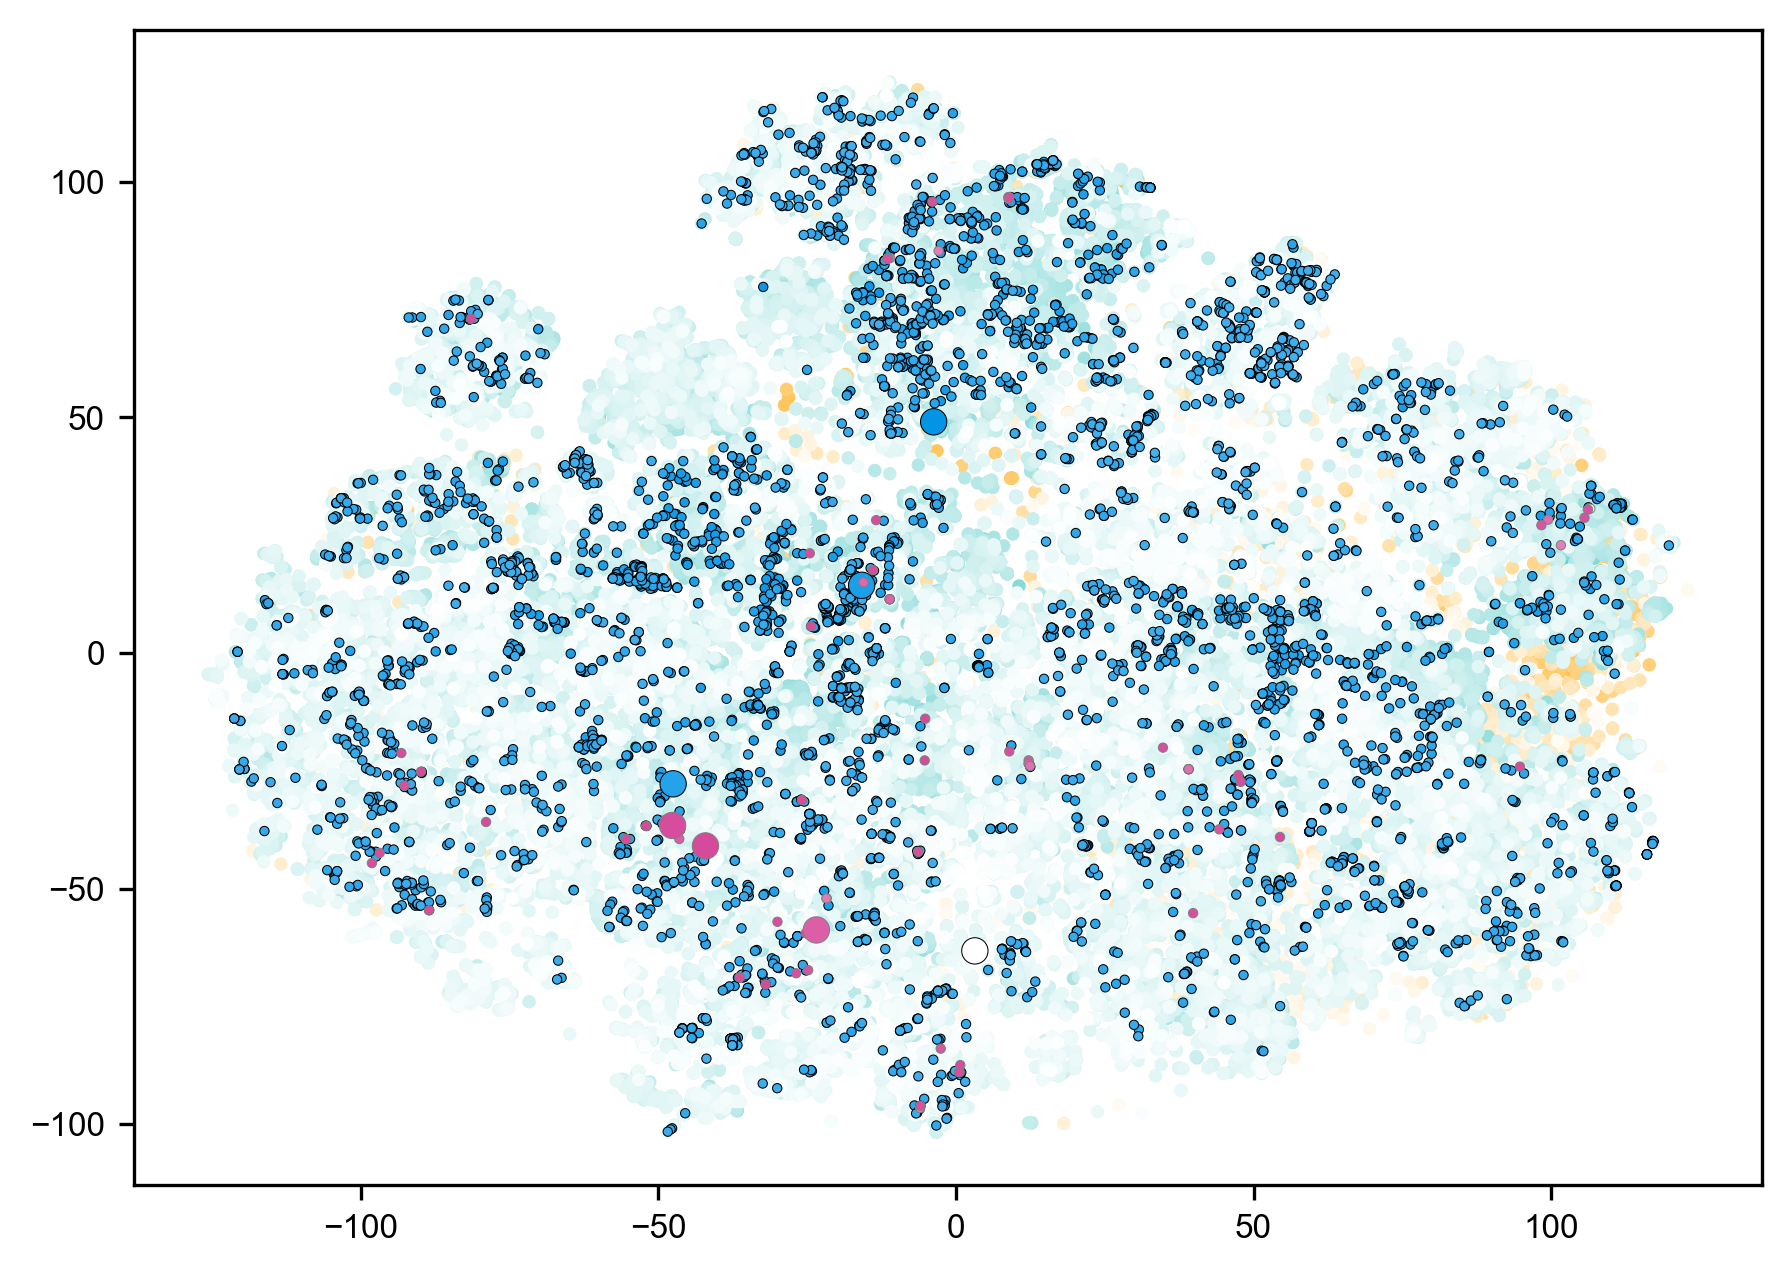

In [10]:
# ## for trial = 24
# fig, ax = plt.subplots(figsize=(7,5))
# cmap1, norm1 = create_cmap(gdb["score"], "orange")  ## orange colormap
# cmap2, norm2 = create_cmap(pub["score"], (0.298, 0.78, 0.77))  ## anvil colormap
# cmap3, norm3 = create_cmap(emol["score"], (0, 0.576, 0.902))  ## blue colormap -- normal scale
# # cmap3, norm3 = create_cmap_log(emol["score"], (0, 0.576, 0.902))  ## blue colormap -- log scale
# cmap4, norm4 = create_cmap(known["score"], (0.839, 0.286, 0.604))  ## purple colormap

# highlight_coords_1 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[:4])][['tsne_0', 'tsne_1']].values]
# highlight_coords_2 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[4:])][['tsne_0', 'tsne_1']].values]

# scatter1 = ax.scatter(gdb["tsne_0"], gdb["tsne_1"], c=gdb["score"], s=5, cmap=cmap1, norm=norm1, label='GDB-17', edgecolors=None)
# scatter2 = ax.scatter(pub["tsne_0"], pub["tsne_1"], c=pub["score"], s=5, cmap=cmap2, norm=norm2, label='PubChem', edgecolors=None)

# mask1_1 = ~emol[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
# scatter3_1 = ax.scatter(emol[mask1_1]["tsne_0"], emol[mask1_1]["tsne_1"], c=emol[mask1_1]["score"], s=5, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)
# mask1_2 = emol[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
# scatter3_2 = ax.scatter(emol[mask1_2]["tsne_0"], emol[mask1_2]["tsne_1"], c=emol[mask1_2]["score"], s=40, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)

# mask2_1 = ~known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
# scatter4_1 = ax.scatter(known[mask2_1]["tsne_0"], known[mask2_1]["tsne_1"], c=known[mask2_1]["score"], s=5, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
# mask2_2 = known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
# scatter4_2 = ax.scatter(known[mask2_2]["tsne_0"], known[mask2_2]["tsne_1"], c=known[mask2_2]["score"], s=40, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
# # scatter3 = ax.scatter(emol["tsne_0"], emol["tsne_1"], c=emol["score"], s=6, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)
# # scatter4 = ax.scatter(known["tsne_0"], known["tsne_1"], c=known["score"], s=6, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
# # scatter2 = ax.scatter(edb_cond["TNSE_0"], edb_cond["TNSE_1"], c=edb_cond["mean_prop"], s=15, cmap=cmap2, norm=norm2, label='EDB-$\sigma$', edgecolors='black')
# # plt.xlim([-10,50])
# # plt.ylim([-10,50])
# # fig.colorbar(scatter1, ax=ax, ticks=[0.44, 0.50, 0.56, 0.62])
# # fig.colorbar(scatter2, ax=ax, ticks=[0.50, 0.55, 0.60, 0.65])
# # fig.colorbar(scatter3_1, ax=ax, ticks=[0.00, 0.20, 0.40, 0.60])
# # fig.colorbar(scatter4_1, ax=ax, ticks=[0.6, 0.7, 0.8, 0.9, 0.99])

# plt.savefig('tsne_fig4c_022424.tiff', dpi=300, bbox_inches='tight')
# # plt.savefig('tsne_fig4c.eps', dpi=300, bbox_inches='tight')

#### new plot (combining emolecules, pubchem, gdb17 together)

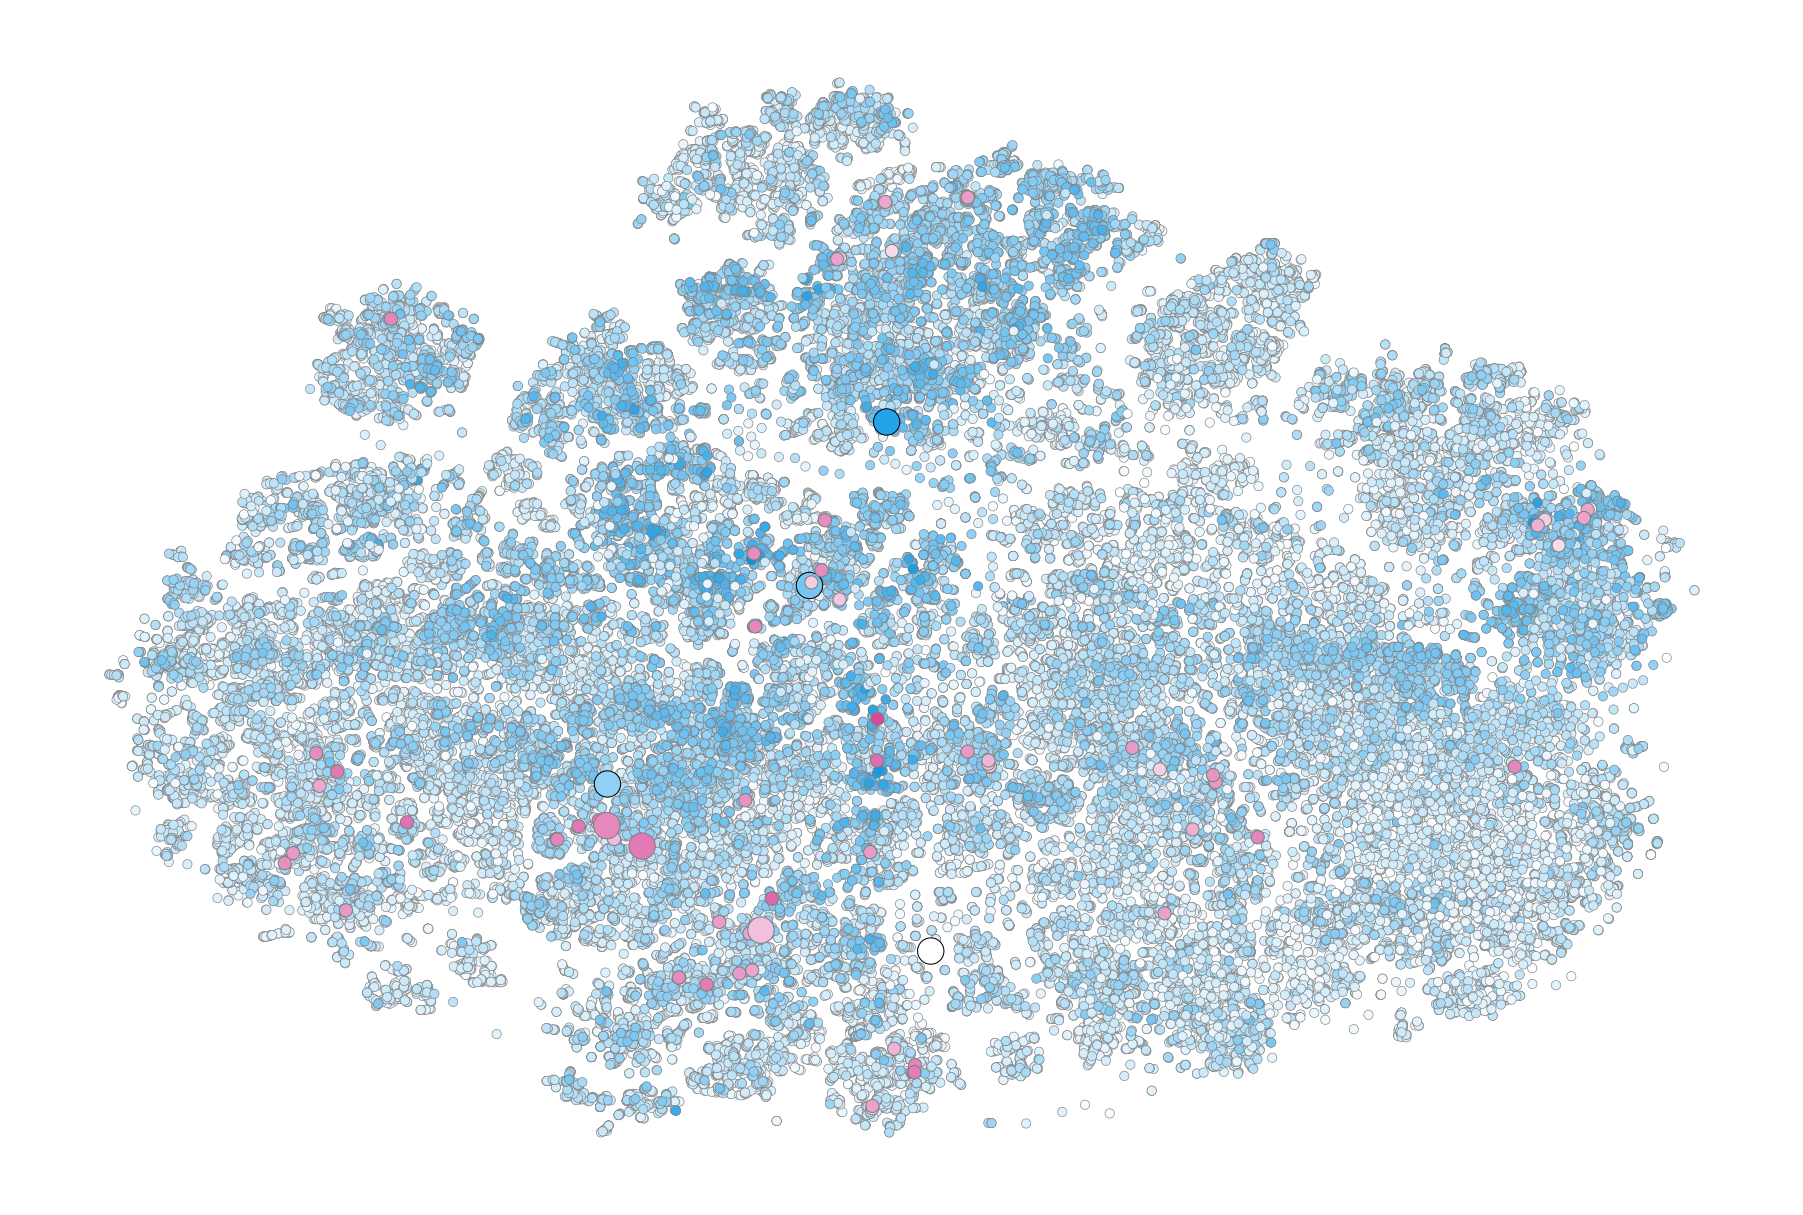

In [58]:
fig, ax = plt.subplots(figsize=(7.5,5))

highlight_coords_1 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[:4])][['tsne_0', 'tsne_1']].values]
highlight_coords_2 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[4:])][['tsne_0', 'tsne_1']].values]

mask1_1 = ~unknown[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
cmap1, norm1 = create_cmap(unknown[mask1_1]["score"], blue)  ## for unlabeled database
scatter1_1 = ax.scatter(unknown[mask1_1]["tsne_0"], unknown[mask1_1]["tsne_1"], c=unknown[mask1_1]["score"], s=5, cmap=cmap1, norm=norm1, label='Unlabeled', edgecolors='grey', linewidths=0.15)
mask1_2 = unknown[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
scatter1_2 = ax.scatter(unknown[mask1_2]["tsne_0"], unknown[mask1_2]["tsne_1"], c=unknown[mask1_2]["score"], s=40, cmap=cmap1, norm=norm1, label='Unlabeled', edgecolors='black', linewidths=0.25)

cmap2, norm2 = create_cmap(known["score_1"], purple)  ## for literature set (over -log(1-CE) rather than CE to distinguish colors)
mask2_1 = ~known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
scatter2_1 = ax.scatter(known[mask2_1]["tsne_0"], known[mask2_1]["tsne_1"], c=known[mask2_1]["score_1"], s=10, cmap=cmap2, norm=norm2, label='Literature (CE)', edgecolors='gray', linewidths=0.25)
mask2_2 = known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
scatter2_2 = ax.scatter(known[mask2_2]["tsne_0"], known[mask2_2]["tsne_1"], c=known[mask2_2]["score_1"], s=40, cmap=cmap2, norm=norm2, label='Literature (CE)', edgecolors='gray', linewidths=0.25)

# fig.colorbar(scatter1_2, ax=ax, ticks=[0.45, 0.50, 0.55, 0.60, 0.65]) ## uncomment to visualize colorbar for unlabeled database
# fig.colorbar(scatter2_1, ax=ax) ## uncomment to visualize colorbar for literature set

plt.xticks([])
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig('plot_tsne_fig4c_020625.tiff', dpi=300, transparent=True)
# plt.savefig('tsne_fig4c.eps', dpi=300)